# Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import keras
from keras import layers
from keras.layers import Conv1D, GRU, Dense, BatchNormalization, Dropout, MaxPool1D,Activation, regularizers
from keras import Sequential
from keras.preprocessing import text
from keras.layers import regularizers
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras import callbacks
from keras.callbacks import Callback
from keras.models import load_model

import scipy.io.wavfile as wav

from sklearn.preprocessing import LabelEncoder

import shutil
import os
from pathlib import Path 
import re
from collections import OrderedDict

from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction as aF


from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score

import pickle

Using TensorFlow backend.


# Data Processing and Saving

In [4]:
path_data = Path('../data/')
os.listdir(path_data)

['wav',
 'spectogram',
 'Schuller_SpeechAnalysis.pdf',
 'time_series_pitch.csv',
 'X_devel_summary.csv',
 'readme.docx',
 'train_4-sec.csv',
 'devel_4-sec.csv',
 'X_train_summary.csv',
 'y_train.npy',
 'ComParE2018_AtypicalAffect.txt',
 'X_test_summary.csv',
 'test_4-sec.csv',
 'X_train_zero_np.npy']

In [8]:
df_labs = pd.read_csv(path_data/'ComParE2018_AtypicalAffect.txt', sep='\t')

def get_raw_data(file):
    [fs,x]  = audioBasicIO.readAudioFile(path_data/'wav'/file)
    [s,t] = aF.stFeatureExtraction(x,fs,0.050*fs,0.025*fs)
    s = s.T
    return s

def fetch_data(directory='wav/', subset='train'):
    sub = df_labs['file_name'].apply(lambda fn: subset in fn)
    df_lab_sub = df_labs[sub]
    y = df_lab_sub['emotion'].values
    fn = df_lab_sub['file_name']
    X = OrderedDict()
    for f in fn:
        X[f] = get_raw_data(f)
        
    return X.values(), y

In [ ]:
(tr_X_raw, tr_y) = fetch_data(directory=path_data/'wav', subset='train')
(dv_X_raw, dv_y) = fetch_data(directory=path_data/'wav', subset='devel')
(test_X_raw, test_y) = fetch_data(directory=path_data/'wav', subset='test')

In [88]:
with open("tr_X_raw.pkl", "wb") as f:
    pickle.dump(list(tr_X_raw), f)
    
with open("dv_X_raw.pkl", "wb") as f:
    pickle.dump(list(dv_X_raw), f)
    
with open("test_X_raw.pkl", "wb") as f:
    pickle.dump(list(test_X_raw), f)
    
    
with open("tr_y.pkl", "wb") as f:
    pickle.dump(tr_y, f)
    
with open("dv_y.pkl", "wb") as f:
    pickle.dump(dv_y, f)
    
with open("test_y.pkl", "wb") as f:
    pickle.dump(test_y, f)

# Resume from here

In [2]:
with open("tr_X_raw.pkl", "rb") as f:
    tr_X_raw = pickle.load(f)
    
with open("dv_X_raw.pkl", "rb") as f:
    dv_X_raw = pickle.load(f)
    
with open("test_X_raw.pkl", "rb") as f:
    test_X_raw = pickle.load(f)
    
    
with open("tr_y.pkl", "rb") as f:
    tr_y = pickle.load(f)
    
with open("dv_y.pkl", "rb") as f:
    dv_y = pickle.load(f)
    
with open("test_y.pkl", "rb") as f:
    test_y = pickle.load(f)

In [3]:
def pad_data(X, pad_len=200, pad_zero=True):
    arr = []
    for x in X:
        if pad_zero:
            x = np.vstack([x, np.zeros((100, x.shape[1]))])[:100][np.newaxis, :, :]
        else:
            x = np.resize(x,(pad_len,x.shape[1]))[np.newaxis, :, :]
        arr.append(x)
    return np.vstack(arr)

In [4]:
tr_X_pad = pad_data(tr_X_raw)
dv_X_pad = pad_data(dv_X_raw)
test_X_pad = pad_data(test_X_raw)

In [5]:
m = np.mean(tr_X_pad.mean(axis=1),axis=0).reshape((1,34))
std = np.mean(tr_X_pad.std(axis=1),axis=0).reshape((1,34))

def normalize(mat):
    mat = (mat - m)/std
    return mat

tr_X = normalize(tr_X_pad)
dv_X = normalize(dv_X_pad)
test_X = normalize(test_X_pad)

In [74]:
# m = np.mean(tr_X_pad.mean(axis=1),axis=0)
# std = np.mean(tr_X_pad.std(axis=1),axis=0)

# def normalize(mat):
#     global m
#     global std
#     m_temp = np.reshape(m,(1,34))
#     std_temp = np.reshape(std,(1,34))
    
#     mat = (mat - m_temp)/std_temp
#     return mat

# for i in range(np.shape(tr_X_pad)[0]):
#     tr_X[i] = normalize(tr_X_pad[i])
    
# for i in range(np.shape(dv_X_pad)[0]):
#     dv_X[i] = normalize(dv_X_pad[i])
    
# for i in range(np.shape(test_X_pad)[0]):
#     test_X[i] = normalize(test_X_pad[i]) 
    
# # tr_X.reshape(-1, 34).mean(axis=0),dv_X.reshape(-1, 34).mean(axis=0),test_X.reshape(-1, 34).mean(axis=0)

In [6]:
le = LabelEncoder()
tr_y = le.fit_transform(tr_y)
dv_y = le.transform(dv_y)
test_y = le.transform(test_y)
le.inverse_transform([0,1,2,3])

array(['angry', 'happy', 'neutral', 'sad'], dtype=object)

In [7]:
from collections import Counter
c = Counter(tr_y)
len(tr_y)/np.asarray(list(c.values())) #class weights based on number of samples

array([ 1.46130302,  4.49798116, 17.87165775, 26.736     ])

In [8]:
class_weight = {0: 23.736,
                1: 4.49798116,
                2: 1.46130302,
                3: 17.87165775}

# same weights but add up to zero (so loss is easier to interpret)
class_weights_rescaled = {i:k/sum(class_weight.values()) for i,k in enumerate(class_weight.values())}
class_weights_rescaled

{0: 0.4990020177233622,
 1: 0.09456107492929176,
 2: 0.030720978913264353,
 3: 0.37571592843408175}

In [9]:
keras.backend.clear_session()
model = Sequential()
model.add(Conv1D(filters=15, kernel_size=10, activation='relu', input_shape=tr_X.shape[1:]))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))

model.add(layers.Flatten())
model.add(Dense(4, activation='sigmoid'))
# model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer=RMSprop(lr=.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 91, 15)            5115      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 45, 15)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 15)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 39, 32)            3392      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
dropout_2 (Dropout)  

In [10]:
class UAR(Callback):
    def on_train_begin(self, logs={}):
        self.val_recalls = []
        self.max_recall = 0

    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax(((self.model.predict(self.validation_data[0]))),
                                axis=1)
        val_targ = self.validation_data[1]
        _val_recall = recall_score(val_targ, val_predict, average="macro")
        self.val_recalls.append(_val_recall)
        print('UAR:'+str(_val_recall))
        if _val_recall > self.max_recall:
            self.max_recall = _val_recall
            self.model.save("1DCNNModel-v3x.h5")
            print('UAR imporved. Saving model\n')
        return _val_recall

uar = UAR()

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                        patience=5, min_lr=.00001)

In [11]:
model.fit(tr_X, tr_y, 
          epochs=100,
          validation_data=(dv_X, dv_y),
          class_weight=class_weights_rescaled, 
          callbacks=[uar, reduce_lr])

Instructions for updating:
Use tf.cast instead.
Train on 3342 samples, validate on 3000 samples
Epoch 1/100
3342/3342 [==============================] - 2s 728us/step - loss: 0.1157 - acc: 0.0637 - val_loss: 1.5631 - val_acc: 0.0733
UAR:0.29224311576215667
UAR imporved. Saving model

Epoch 2/100
3342/3342 [==============================] - 2s 669us/step - loss: 0.1123 - acc: 0.0730 - val_loss: 1.5147 - val_acc: 0.0710
UAR:0.3607057610936313
UAR imporved. Saving model

Epoch 3/100
3342/3342 [==============================] - 3s 784us/step - loss: 0.1114 - acc: 0.0715 - val_loss: 1.4867 - val_acc: 0.0687
UAR:0.36123152431332967
UAR imporved. Saving model

Epoch 4/100
3342/3342 [==============================] - 3s 749us/step - loss: 0.1101 - acc: 0.0718 - val_loss: 1.4782 - val_acc: 0.0650
UAR:0.3509109210801735
Epoch 5/100
3342/3342 [==============================] - 3s 768us/step - loss: 0.1086 - acc: 0.0805 - val_loss: 1.4741 - val_acc: 0.0680
UAR:0.3620233198865075
UAR imporved. Savi

3342/3342 [==============================] - 3s 753us/step - loss: 0.0982 - acc: 0.1517 - val_loss: 1.4524 - val_acc: 0.1050
UAR:0.3745293211894978
Epoch 49/100
3342/3342 [==============================] - 3s 773us/step - loss: 0.0981 - acc: 0.1508 - val_loss: 1.4530 - val_acc: 0.1033
UAR:0.373224457689718
Epoch 50/100
3342/3342 [==============================] - 3s 784us/step - loss: 0.0981 - acc: 0.1508 - val_loss: 1.4534 - val_acc: 0.1027
UAR:0.36575427384972364
Epoch 51/100
3342/3342 [==============================] - 3s 762us/step - loss: 0.0982 - acc: 0.1448 - val_loss: 1.4531 - val_acc: 0.1040
UAR:0.3727557265033502
Epoch 52/100
3342/3342 [==============================] - 3s 766us/step - loss: 0.0982 - acc: 0.1448 - val_loss: 1.4516 - val_acc: 0.1043
UAR:0.372650152767587
Epoch 53/100
3342/3342 [==============================] - 3s 756us/step - loss: 0.0982 - acc: 0.1451 - val_loss: 1.4520 - val_acc: 0.1053
UAR:0.36579755786039897
Epoch 54/100
3342/3342 [=======================

UAR:0.3724263874314466
Epoch 99/100
3342/3342 [==============================] - 3s 826us/step - loss: 0.0962 - acc: 0.1735 - val_loss: 1.4441 - val_acc: 0.1190
UAR:0.3719502603359996
Epoch 100/100
3342/3342 [==============================] - 3s 749us/step - loss: 0.0965 - acc: 0.1771 - val_loss: 1.4428 - val_acc: 0.1150
UAR:0.3620994410187701


In [13]:
model_best = load_model('1DCNNModel-v3x.h5')

# Results

In [14]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def reporting(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, target_names=np.unique(y_test))
#     print(confusion_matrix)
    print("\n",classification_report(y_test,y_pred))
    print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
    print(f'UAR: {recall_score(y_test,y_pred, average="macro")}')

## Validation Set

In [15]:
y_pred = model_best.predict(dv_X)
y_pred = y_pred.argmax(axis = 1)

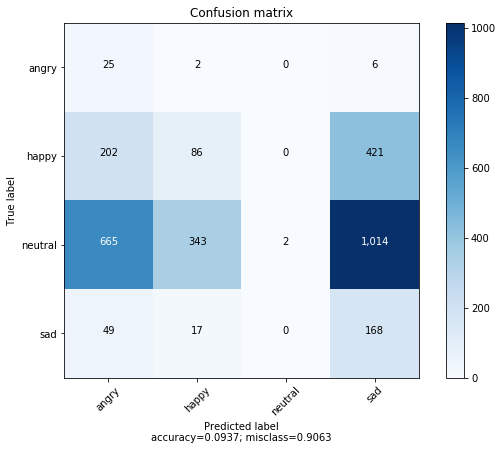


               precision    recall  f1-score   support

       angry       0.03      0.76      0.05        33
       happy       0.19      0.12      0.15       709
     neutral       1.00      0.00      0.00      2024
         sad       0.10      0.72      0.18       234

   micro avg       0.09      0.09      0.09      3000
   macro avg       0.33      0.40      0.10      3000
weighted avg       0.73      0.09      0.05      3000

Accuracy: 0.09366666666666666
UAR: 0.3994525550184163


In [16]:
reporting(le.inverse_transform(dv_y), le.inverse_transform(y_pred)) #on validation set

## Test Set

In [17]:
#test prediction 
y_pred_t = model_best.predict(test_X)
y_pred_t = y_pred_t.argmax(axis = 1)

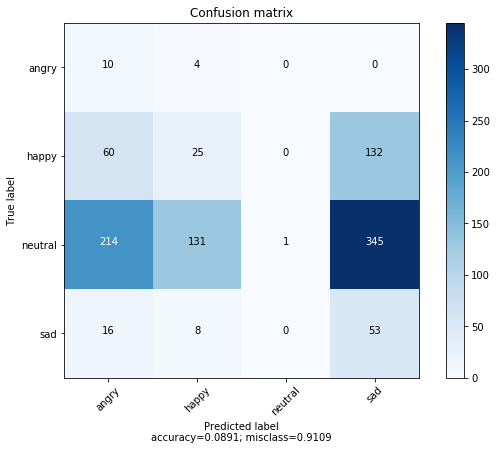


               precision    recall  f1-score   support

       angry       0.03      0.71      0.06        14
       happy       0.15      0.12      0.13       217
     neutral       1.00      0.00      0.00       691
         sad       0.10      0.69      0.17        77

   micro avg       0.09      0.09      0.09       999
   macro avg       0.32      0.38      0.09       999
weighted avg       0.73      0.09      0.04       999

Accuracy: 0.0890890890890891
UAR: 0.37981298846804656


In [ ]:
reporting(le.inverse_transform(test_y), le.inverse_transform(y_pred_t))